In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import nibabel as nib
from nilearn import image
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

import matplotlib.pyplot as plt
import seaborn as sns

import param
from param import rx
import holoviews as hv
import panel as pn
import pyvista as pv
import hvplot.pandas
from holoviews.operation.datashader import rasterize
from functools import partial
from scipy.ndimage import zoom
import streamz
from holoviews.streams import Pipe, Buffer

from panel.viewable import Viewer

pn.extension('vtk')

os.chdir('/Users/burkelawlor/Repos/i2-viz')


In [2]:
# Load metadata
run_ratings_dict = {
    'sub-01_ses-V1_task-S2_run-02_space-MNI152NLin2009cAsym_res-2_desc-denoisedSmoothed_bold':'PID1_v1_s2_r2 - 2023-09-01',
    'sub-01_ses-V1_task-S1_run-03_space-MNI152NLin2009cAsym_res-2_desc-denoisedSmoothed_bold':'PID1_v1_s1_r3 - 2023-09-01',
    'sub-01_ses-V1_task-S0_run-01_space-MNI152NLin2009cAsym_res-2_desc-denoisedSmoothed_bold':'PID1_v1_s0_r1 - 2023-08-31'
}
run_options = list(run_ratings_dict.keys())

parcel_labels = pd.read_csv('data/Schaefer2018_100Parcels_7Networks_order.txt', sep='\t', names=['label', 'parcellation', 'x', 'y', 'z', 't'])['parcellation'].to_list()
parcel_labels_map = {v: k for k, v in dict(enumerate(parcel_labels, start=1)).items()}
default_parcels = [p for p in parcel_labels if "Default" in p]

In [3]:
def load_ratings(ratings_path):
    ratings_df = pd.read_csv(ratings_path)
    ratings_df.columns = ratings_df.columns.str.strip()
    ratings_df.Question = ratings_df.Question.str.strip()
    return ratings_df

In [4]:
class I2Run:
    _cache = {}

    def __init__(self, run_prefix, window_size=44, step_size=2, frame_ms=900):
        self.run_prefix = run_prefix
        self.window_size = window_size
        self.step_size = step_size
        self.frame_ms = frame_ms
        
        self.load_data()


    def load_data(self):

        if self.run_prefix in I2Run._cache:
            print(f"Loading {self.run_prefix} from cache.")
            cached_data = I2Run._cache[self.run_prefix]
            self.__dict__.update(cached_data)
        else:
            print(f"Loading new data for {self.run_prefix}.")
            # Load image and ratings based on the current run_prefix
            self.run_img = nib.load(f'data/signal_intensity/{self.run_prefix}.nii.gz')
            self.ratings_prefix = run_ratings_dict[self.run_prefix]
            self.ratings_df = load_ratings(f'data/ratings/{self.ratings_prefix}.csv')

            # Load and resample parcellation image
            self.parcel_img_raw = nib.load('data/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii')
            self.parcel_img_resampled = image.resample_img(self.parcel_img_raw, target_affine=self.parcel_img_raw.affine, target_shape=self.run_img.shape[:3])

            # Load parcellation info
            self.parcel_info_df = pd.read_csv('data/Schaefer2018_100Parcels_7Networks_order.csv')
            self.n_parcels = len(self.parcel_info_df)

            # Load or create parcellated data
            if os.path.isfile(f'data/signal_intensity/{self.run_prefix}_parcellated.nii.gz') and os.path.isfile(f'data/signal_intensity/{self.run_prefix}_parcellated_timeseries.npy'):
                self.run_img_parcellated = nib.load(f'data/signal_intensity/{self.run_prefix}_parcellated.nii.gz')
                self.timeseries = np.load(f'data/signal_intensity/{self.run_prefix}_parcellated_timeseries.npy')
            else:
                print('Parcellated file does not exist, performing parcellation...')
                self.parcellate()

            # Functional connectivities
            self.calculate_functional_connectivities()

            # Cache the instance data for future use
            I2Run._cache[self.run_prefix] = self.__dict__.copy()
    
    
    def parcellate(self, out=True):
        '''Parcellate the target image according to Schaefer 100 parcellation'''
        masker = NiftiLabelsMasker(
            self.parcel_img_resampled,
            labels=['Background'] + list(self.parcel_info_df['full_name']),
            smoothing_fwhm=6,
            standardize='zscore_sample',
            memory='nilearn_cache',
        )
        self.timeseries = masker.fit_transform(self.run_img)
        self.run_img_parcellated = masker.inverse_transform(self.timeseries)

        if out:
            out_path = f'data/signal_intensity/{self.run_prefix}_parcellated.nii.gz'
            nib.save(self.run_img_parcellated, out_path)
            print(f'Saved parcellated file to {out_path}')

            out_path = f'data/signal_intensity/{self.run_prefix}_parcellated_timeseries.npy'
            np.save(out_path, self.timeseries)
            print(f'Saved timeseries to {out_path}')

    def calculate_functional_connectivities(self):
        
        self.calculate_windows()

        # dfc matrix
        if os.path.isfile(f'data/functional_connectivity/{self.run_prefix}_dynamic_fc.npy'):
            self.dfc_matrix = np.load(f'data/functional_connectivity/{self.run_prefix}_dynamic_fc.npy')
        else:
            print('Dynamic FC matrix does not exist, performing calculations...')
            self.dfc_matrix = self.dynamic_fuctional_connectivity_matrix()

        # dgfc matrix
        self.dgfc_matrix = self.dyamic_global_functional_connectivity()

        # dgfc volume
        if os.path.isfile(f'data/functional_connectivity/{self.run_prefix}_dynamic_gfc.nii.gz'):
            self.dgfc_img = nib.load(f'data/functional_connectivity/{self.run_prefix}_dynamic_gfc.nii.gz')
        else:
            print('Global functional connectivity volumes do not exist, performing calculations...')
            self.dgfc_img = self.dynamic_global_functional_connectivity_volumes()

        self.dgfc_vol = self.dgfc_img.get_fdata()

    def calculate_windows(self):
        self.n_windows = (self.run_img.shape[-1] - self.window_size) // self.step_size + 1
        self.window_timestamps = (np.arange(self.n_windows) * self.step_size + self.window_size // 2) * self.frame_ms / 1000


    def dynamic_fuctional_connectivity_matrix(self, out=True):
        '''
        For each window in a sliding window, calculate the functional connectivity matrix.
        The FC matrix is the correlation of activity between each pair of parcels in Schafer 100 parcels.
        Produces a 3D matrix of shape (n_windows, 100, 100) where n_windows is the number of windows.
        '''

        # Initialize dynamic correlation matrices
        dfc_matrix = np.zeros((self.n_windows, 100, 100))

        # Calculate connectivity matrix for each time window
        for i in range(self.n_windows):
            window_timeseries = self.timeseries[i * self.step_size:i * self.step_size + self.window_size, :]
            correlation_measure = ConnectivityMeasure(
                kind="correlation",
                standardize="zscore_sample",
            )
            fc = correlation_measure.fit_transform([window_timeseries])[0]
            np.fill_diagonal(fc, 0)
            dfc_matrix[i] = fc

        if out:
            out_path = f'data/functional_connectivity/{self.run_prefix}_dynamic_fc.npy'
            np.save(out_path, dfc_matrix)
            print(f'Saved dynamic FC matrix to {out_path}')

        return dfc_matrix

    def dyamic_global_functional_connectivity(self):
        '''
        Calculate the global functional connectivity of the brain for each window.
        The GFC is the average correlation of activity between each parcel and the rest of the brain.
        Produces a 1D array of shape (n_windows, n_parcels).
        '''
        return np.array([np.sum(W, axis=0) / (self.n_parcels - 1) for W in self.dfc_matrix])

    def dynamic_global_functional_connectivity_volumes(self, out=True):
        '''
        Maps the global functional connectivity to a 4D volume. Returns a nibabel image.
        '''

        # Create a template volume of parcel labels
        frame_template = self.parcel_img_resampled.get_fdata()
        x, y, z = frame_template.shape
        
        # initialize an empty array to store the volumes
        volumes = np.zeros((x, y, z, self.n_windows)) 

        for i in tqdm(range(self.n_windows), desc="Generating volumes"):
            frame_volume = frame_template.copy()
            frame_values = self.dynamic_gfc[i] # get the GFC values for the frame
            frame_values_map = dict(enumerate(frame_values, 1)) # make a map of parcels to GFC values

            # Replace the parcel labels in the template volume with the GFC values
            for parcel, gfc_value in frame_values_map.items():
                frame_volume[frame_volume == parcel] = gfc_value

            volumes[:, :, :, i] = frame_volume

        dgfc_img = nib.Nifti1Image(volumes, affine=self.parcel_img_resampled.affine)

        if out:
            out_path = f'data/functional_connectivity/{self.run_prefix}_dynamic_gfc.nii.gz'
            nib.save(dgfc_img, out_path)
            print(f'Saved global functional connectivity volumes to {out_path}')
        
        return dgfc_img

In [30]:
# # Instantiate the I2Run object for testing
# run = I2Run(run_prefix=run_options[0])

In [5]:
def normalize_to_symmetric_range(min_val: float, max_val: float) -> tuple[float, float]:
    """
    Adjusts the input values to create a symmetric range around zero.
    """
    # Determine the larger absolute value
    max_abs_val = max(abs(min_val), abs(max_val))
    
    # Create a symmetric range around zero
    min_norm = -max_abs_val
    max_norm = max_abs_val
    
    return min_norm, max_norm

In [6]:
# adapted from https://panel.holoviz.org/gallery/vtk_slicer.html

def image_slice(dims, array, low, high, bounds, cmap='seismic', colorbar=True):
    img = hv.Image(array, bounds=bounds, kdims=dims, vdims='Intensity')
    return img.opts(clim=(low, high), cmap=cmap, colorbar=colorbar) 

def image_slice_i(si, vol, low, high, cmap='seismic'):
    array = vol[si, :, :].T
    bounds = (0, 0, vol.shape[1]-1, vol.shape[2]-1)
    return image_slice(['y','z'], array, low, high, bounds, cmap)

def image_slice_j(sj, vol, low, high, cmap='seismic'):
    array = vol[:, sj, :].T
    bounds = (0, 0, vol.shape[0]-1, vol.shape[2]-1)
    return image_slice(['x','z'], array, low, high, bounds, cmap)

def image_slice_k(sk, vol, low, high, cmap='seismic'):
    array = vol[:, :, sk].T
    bounds = (0, 0, vol.shape[0]-1, vol.shape[1]-1)
    return image_slice(['x','y'], array, low, high, bounds, cmap)

In [6]:
from bokeh.models import GlyphRenderer, LinearAxis, LinearScale, Range1d

def overlay_hook(plot, element):
    # Adds a secondary y-axis (right)
    p = plot.handles['plot']

    if 'right' not in p.extra_y_scales:
        p.extra_y_scales = {'right': LinearScale()}
        p.extra_y_ranges = {'right': Range1d(start=-0.5, end=4.5)}
        p.add_layout(LinearAxis(y_range_name='right'), 'right')

        # Assign scatterplots to the right axis
        lines = [p for p in p.renderers if isinstance(p, GlyphRenderer)]
        lines[-1].y_range_name = "right"
        lines[-2].y_range_name = "right"
        lines[-3].y_range_name = "right"

def vertical_line_callback(time_current):
    # Get the current timestamp based on frame_player value
    return hv.VLine(time_current).opts(color='red', line_width=2, line_dash='dashed')

In [7]:
cmap = 'seismic'

class I2Explorer(param.Parameterized):
    
    # Parametrized instance of I2Run for data loading
    run = param.ClassSelector(class_=I2Run, doc="Instance of I2Run to load data for selected run")

    # Parameters for user selections
    run_select = param.Selector(objects=run_options, label="Select a run", doc="Prefix of the I2 run")
    parcels_select = param.ListSelector(default=default_parcels, objects=parcel_labels, label="Select parcels", doc="Brain parcellations according to Schaefer 100 atlas")
    parcels_dgfc_vol = param.Parameter(doc="Filtered data for selected parcels")
    parcels_dfc_matrix = param.Parameter(doc="Dynamic functional connectivity matrix for selected parcels")

    frame_player = param.Integer(1, bounds=(1, 100), label="Frame")

    i_slice = param.Integer(97//2, bounds=(1, 97), label="i slice")
    j_slice = param.Integer(115//2, bounds=(1, 115), label="j slice")
    k_slice = param.Integer(97//2, bounds=(1, 97), label="k slice")
    center_slice = param.Action(lambda self: self.reset_slices(), label="Center slices") 

    
    def __init__(self, **params):
        super().__init__(**params)
        self.update_run() 
        self.update_frame()
        

    @param.depends('run_select', watch=True)
    def update_run(self):
        self.run = I2Run(self.run_select)
        
        self.fc_clim = normalize_to_symmetric_range(self.run.dfc_matrix.min(), self.run.dfc_matrix.min())
        self.gfc_clim = normalize_to_symmetric_range(self.run.dgfc_matrix.min(), self.run.dgfc_matrix.max())
        
        self.update_parcels()

        self.param.frame_player.bounds = (1, self.run.n_windows)
        self.param.i_slice.bounds = (1, self.run.run_img.shape[0])
        self.param.j_slice.bounds = (1, self.run.run_img.shape[1])
        self.param.k_slice.bounds = (1, self.run.run_img.shape[2])        
        

    @param.depends('parcels_select', watch=True)
    def update_parcels(self):
        
        parcels_idx = np.array([parcel_labels_map[p] for p in self.parcels_select])

        # Update gdfc volume
        self.parcels_vol_mask = np.isin(self.run.parcel_img_resampled.get_fdata(), parcels_idx)
        parcels_d_vol_mask = np.broadcast_to(self.parcels_vol_mask[..., None], self.run.dgfc_vol.shape)
        self.parcels_dgfc_vol = np.where(parcels_d_vol_mask, self.run.dgfc_vol, 0)

        # Update dfc & gdfc matrix
        self.parcels_dfc_matrix = self.run.dfc_matrix[:,parcels_idx-1][:,:,parcels_idx-1]
        self.parcels_dgfc_matrix = self.run.dgfc_matrix[:,parcels_idx-1]


    @param.depends('run_select', 'parcels_select', 'frame_player', watch=True)
    def update_frame(self):
        self.frame_vol = self.parcels_dgfc_vol[..., self.frame_player - 1]
        self.frame_matrix = self.parcels_dfc_matrix[self.frame_player - 1]
    
    @param.depends('run_select', 'parcels_select', 'frame_player', 'i_slice', 'j_slice', 'k_slice')
    def slices_display(self):
        slice_common = dict(
            vol = self.frame_vol,
            low=self.gfc_clim[0],
            high=self.gfc_clim[1],
            cmap=cmap
        )
        
        dmap_common = dict(
            width=425,
            height=390
        )

        dmap_i = rasterize(hv.DynamicMap(pn.bind(image_slice_i, si=self.i_slice, **slice_common)).opts(title='slice i', **dmap_common))
        dmap_j = rasterize(hv.DynamicMap(pn.bind(image_slice_j, sj=self.j_slice, **slice_common)).opts(title='slice j', **dmap_common))
        dmap_k = rasterize(hv.DynamicMap(pn.bind(image_slice_k, sk=self.k_slice, **slice_common)).opts(title='slice k', **dmap_common))

        # fix for common colorbar here likely here... or i'll have to build it to also match the heatmap
        return pn.Row((dmap_i + dmap_j + dmap_k).opts(shared_axes=True)) 
        

    @param.depends('run_select','parcels_select', 'i_slice', 'j_slice', 'k_slice')
    def volume_display(self):
        # arr = np.where(self.selected_parcels_mask_3d, 1., np.nan) # nan option
        arr = self.parcels_vol_mask.astype(float) # bool option
        
        volume = pn.pane.VTKVolume(
                arr,  orientation_widget=True,
                display_slices=True, display_volume=True,
                render_background='#ffffff', colormap='Grayscale'

        )
        volume.slice_i = self.i_slice
        volume.slice_j = self.j_slice
        volume.slice_k = self.k_slice
        
        return pn.Row(pn.layout.HSpacer(),volume, pn.layout.HSpacer())
    
    
    @param.depends('run_select', 'parcels_select', 'frame_player')
    def dfc_matrix_display(self):
        dfc_df = pd.DataFrame(self.frame_matrix, index=self.parcels_select, columns=self.parcels_select)
        dfc_heatmap = dfc_df.hvplot.heatmap(
            title=f'fc matrix', width=650, height=500, flip_yaxis=True, clim=self.fc_clim
        ).opts(cmap=cmap, xrotation=45)

        return dfc_heatmap


    @param.depends('run_select', 'parcels_select', 'frame_player')
    def lineplot_display(self):
        # Set up data for GFC lineplot
        y_parcels = pd.DataFrame(self.parcels_dgfc_matrix, columns=self.parcels_select)
        y_parcels['time'] = self.run.window_timestamps
        y_parcels = y_parcels.melt(id_vars='time', var_name='parcel', value_name='gdfc')

        # Set up data for functional ratings scatterplot
        functional_questions = ['Positive/Negative','Acceptance/Resistance','No Insight/Strong Insight']
        functional_ratings = self.run.ratings_df[self.run.ratings_df.Question.isin(functional_questions)]

        # Create hvplot elements
        lineplot = y_parcels.hvplot.line(x='time', y='gdfc', by='parcel', alpha=0.1, legend=False) * \
                    y_parcels.groupby('time').gdfc.mean().reset_index().hvplot.line(x='time', y='gdfc', color='black', label='Mean GFC')

        scatterplot = functional_ratings.hvplot.scatter(x='Seconds since start', y='Answer', by='Question', legend='top_left')
        # vertical_line = hv.DynamicMap(pn.bind(hv.VLine, self.frame_player, color='red', line_width=2, line_dash='dashed'))
        vertical_line = hv.DynamicMap(pn.bind(vertical_line_callback, time_current=self.run.window_timestamps[self.frame_player - 1]))

        final_lineplot = (lineplot * scatterplot * vertical_line).opts(
            title="GFC of selected parcels and subjective ratings with Current Time",
            xlabel="Time (s)",
            ylabel="GFC",
            ylim=(-0.3, 0.5),
            hooks=[overlay_hook],
            legend_position='bottom',
        )
        return final_lineplot


    def reset_slices(self):
        """Set slices to center of selected parcels."""

        # This is a hacky way to find the center... will improve later
        indices = np.where(self.parcels_vol_mask)
        centroid = np.mean(indices, axis=0)

        self.i_slice = int(centroid[0])
        self.j_slice = int(centroid[1])
        self.k_slice = int(centroid[2])
        
    @param.depends('run_select', 'parcels_select')
    def header(self):
        """Dynamically updates the markdown block with current selections."""
        return pn.pane.Markdown(f"""
            ### Run Metadata
            - **Run prefix**: {self.run.run_prefix} 
            - **Ratings prefix**: {self.run.ratings_prefix}
            - **Window size**: {self.run.window_size}
            - **Volume shape**: {self.parcels_dgfc_vol.shape}
            - **Number of selected parcels**: {len(self.parcels_select)}
            - **Sum values of selected parcels**: {self.parcels_dgfc_vol.sum()}
            - **Selected parcels**: {', '.join(self.parcels_select)}
        """, sizing_mode="stretch_width")



    
    def __panel__(self):
        template = pn.template.VanillaTemplate(
            title='I2 Run Explorer'
        )
        template.sidebar.append(
            pn.Column(
                self.param.run_select,
                pn.widgets.MultiSelect.from_param(self.param.parcels_select, size=8),
                pn.Spacer(height=20),
                
                pn.panel('## Time controller'),
                pn.widgets.Player.from_param(self.param.frame_player, value=0, loop_policy='loop', show_value=True, width=310),
                pn.Spacer(height=20),
                
                pn.panel('## Slice controller'),
                pn.Column(self.param.i_slice, self.param.j_slice, self.param.k_slice),
                pn.widgets.Button.from_param(self.param.center_slice),
            
            )
        )

        # Main content setup
        main_content = pn.Column(
            self.header,
            self.volume_display,
            self.slices_display,
            pn.Row(self.dfc_matrix_display, self.lineplot_display),
        )
        template.main.append(main_content)

        return template


In [9]:
explorer = I2Explorer()
# explorer.__panel__().show() 

Loading new data for sub-01_ses-V1_task-S2_run-02_space-MNI152NLin2009cAsym_res-2_desc-denoisedSmoothed_bold.


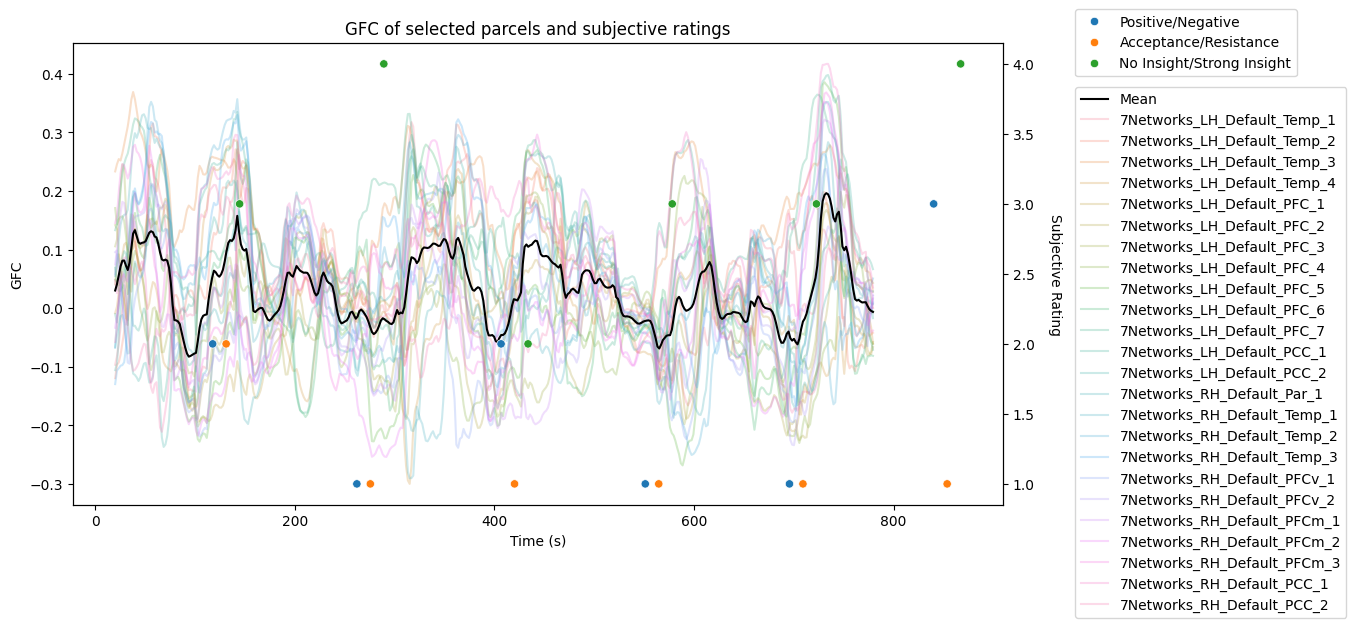

In [ ]:
### Matplotlib implementation of the lineplot

# Set up data for GFC lineplot
y_parcels = pd.DataFrame(explorer.parcels_dgfc_matrix, columns=explorer.parcels_select)
y_parcels['time'] = explorer.run.window_timestamps
y_parcels = y_parcels.melt(id_vars='time', var_name='parcel', value_name='gdfc')

# Set up data for functional ratings scatterplot
functional_questions = ['Positive/Negative','Acceptance/Resistance','No Insight/Strong Insight']
functional_ratings = explorer.run.ratings_df[explorer.run.ratings_df.Question.isin(functional_questions)]

# Lineplot for GFC
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.lineplot(data=y_parcels, x='time', y='gdfc', hue='parcel', alpha=0.25, ax=ax1)
sns.lineplot(x=explorer.run.window_timestamps, y=explorer.parcels_dgfc_matrix.mean(axis=1), color='black', label='Mean', ax=ax1)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('GFC')

# Scatterplot for functional ratings
ax2 = ax1.twinx()
sns.scatterplot(data=functional_ratings, x='Seconds since start', y='Answer', hue='Question', ax=ax2)
ax2.set_ylabel('Subjective Rating', rotation=270, labelpad=20)

# legend and title
ax2.legend(loc='center left', bbox_to_anchor=(1.07, 1))
handles, labels = ax1.get_legend_handles_labels()
ax1.legend([handles[-1]] + handles[:-1], ['Mean'] + labels[:-1], loc='center left', bbox_to_anchor=(1.07, 0.33))
ax1.set_title('GFC of selected parcels and subjective ratings')
plt.show()